### Generation of Image-Mask Pairs using InChannel and ControlNet

In [ ]:
# !pip install -q diffusers==0.24.0 torch==2.2.1 torchviz==0.0.2 transformers==4.36.0

In [1]:
!nvidia-smi

Tue Dec 17 11:22:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:41:00.0 Off |                  Off |
|  0%   26C    P8              14W / 450W |   7649MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from diffusers import AutoPipelineForText2Image,ControlNetModel,StableDiffusionControlNetPipeline
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

/home/fangyijie/miniconda3/envs/sd_ft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# pipeline for in-channel generation

pipe_inchan = AutoPipelineForText2Image.from_pretrained("/mnt/storage/fangyijie/sd_ft/models", torch_dtype=torch.float16, safety_checker=None).to("cuda")

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.67it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [4]:
# load LORA weights for inchannel generation
# femur: /home/fangyijie/sd_ft/sd-fetal-femur-model-lora
# head: /home/fangyijie/sd_ft/sd-fetal-head-model-lora
pipe_inchan.load_lora_weights("/home/fangyijie/sd_ft/sd-fetal-head-model-lora", 
    weight_name="pytorch_lora_weights.safetensors")

### Standalone Image Generation

In [5]:
from diffusers import DPMSolverMultistepScheduler, EulerDiscreteScheduler, UniPCMultistepScheduler

pipe_inchan.scheduler = UniPCMultistepScheduler.from_config(pipe_inchan.scheduler.config)

100%|██████████| 50/50 [00:01<00:00, 30.75it/s]


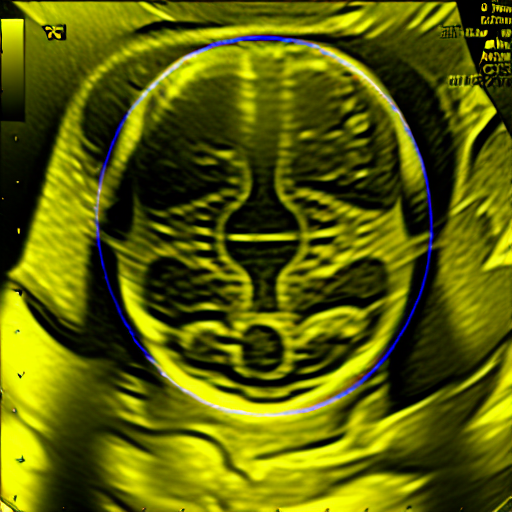

In [6]:
prompt = "a photo of standard maternal fetal ultrasound planes, fetal head"
# prompt = "a photo of standard maternal fetal ultrasound planes, fetal femur"

generator = torch.Generator(device="cuda").manual_seed(-1)
image = pipe_inchan(prompt=prompt, num_inference_steps=50).images[0]
image

In [7]:
from PIL import Image, ImageFilter

In [8]:
IMG_W = 400
IMG_H = 270
image = image.resize((IMG_W, IMG_H))

In [9]:
# convert PIL image to numpy
img = np.array(image)
print(img.shape)
red = img[:,:,0]
green = img[:,:,1]
blue = img[:,:,2]

(270, 400, 3)


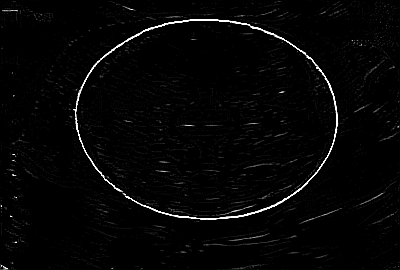

In [10]:
s_mask = Image.fromarray(blue)
image2 = s_mask.filter(ImageFilter.FIND_EDGES)
image2

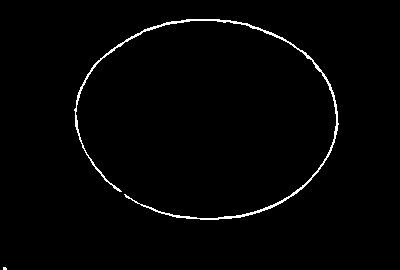

In [12]:
# Define the threshold
threshold = 100

# Apply the threshold to create a binary image
binary_array = (blue > threshold) * 255  # Sets pixels above threshold to 255 (white), else 0 (black)
binary_array = binary_array.astype(np.uint8)    # Convert to uint8 type for image compatibility

# Convert the binary array back to an image
binary_image = Image.fromarray(binary_array)
binary_image

In [13]:
# Convert the NumPy array to a PIL image
s_image = Image.fromarray(red)
s_mask = Image.fromarray(blue)


Create multiple image-mask pairs and save them - these will be used

**Without ControlNet**

In [20]:
output_dir = '/mnt/storage/fangyijie/sd_ft/data/head/synth_data_noCN/'
# output_dir = '/mnt/storage/fangyijie/sd_ft/data/femur/synth_data_noCN/'

N_images = 0
IMG_W = 400
IMG_H = 270
prompt = "a photo of standard maternal fetal ultrasound planes, fetal head"
# prompt = "a photo of standard maternal fetal ultrasound planes, fetal femur"
num_inference_steps = 30

# Define the threshold for binarization
threshold = 180

for i in range(N_images,500):
  pipe_gen = pipe_inchan(prompt, cross_attention_kwargs={"scale": 0.9}, num_inference_steps=num_inference_steps)
  image = pipe_gen.images[0]
  # image = image.resize((IMG_W, IMG_H))
  img = np.array(image)
  red = img[:,:,0]
  green = img[:,:,1]
  blue = img[:,:,2]

  # Apply the threshold to create a binary image
  binary_array = (blue > threshold) * 255
  binary_array = binary_array.astype(np.uint8)

  # Convert the binary array back to an image
  binary_image = Image.fromarray(binary_array)

  s_image = Image.fromarray(red)
  s_mask = binary_image
  s_image.save(f'{output_dir}T2syn{i}_{num_inference_steps}_HC.png')
  s_mask.save(f'{output_dir}T2syn{i}_{num_inference_steps}_HC_Annotation.png')

  print(f'Generated {i+1} images')

  # break

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


Generated 1 images


100%|██████████| 30/30 [00:00<00:00, 32.47it/s]


Generated 2 images


100%|██████████| 30/30 [00:00<00:00, 32.43it/s]


Generated 3 images


100%|██████████| 30/30 [00:00<00:00, 32.29it/s]


Generated 4 images


100%|██████████| 30/30 [00:00<00:00, 32.52it/s]


Generated 5 images


100%|██████████| 30/30 [00:00<00:00, 32.50it/s]


Generated 6 images


100%|██████████| 30/30 [00:00<00:00, 32.46it/s]


Generated 7 images


100%|██████████| 30/30 [00:00<00:00, 31.95it/s]


Generated 8 images


100%|██████████| 30/30 [00:00<00:00, 32.49it/s]


Generated 9 images


100%|██████████| 30/30 [00:00<00:00, 32.57it/s]


Generated 10 images


100%|██████████| 30/30 [00:00<00:00, 32.44it/s]


Generated 11 images


100%|██████████| 30/30 [00:00<00:00, 32.62it/s]


Generated 12 images


100%|██████████| 30/30 [00:00<00:00, 32.51it/s]


Generated 13 images


100%|██████████| 30/30 [00:00<00:00, 32.42it/s]


Generated 14 images


100%|██████████| 30/30 [00:00<00:00, 32.38it/s]


Generated 15 images


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Generated 16 images


100%|██████████| 30/30 [00:00<00:00, 32.53it/s]


Generated 17 images


100%|██████████| 30/30 [00:00<00:00, 32.28it/s]


Generated 18 images


100%|██████████| 30/30 [00:00<00:00, 32.55it/s]


Generated 19 images


100%|██████████| 30/30 [00:00<00:00, 32.05it/s]


Generated 20 images


100%|██████████| 30/30 [00:00<00:00, 32.52it/s]


Generated 21 images


100%|██████████| 30/30 [00:00<00:00, 32.64it/s]


Generated 22 images


100%|██████████| 30/30 [00:00<00:00, 32.49it/s]


Generated 23 images


100%|██████████| 30/30 [00:00<00:00, 32.59it/s]


Generated 24 images


100%|██████████| 30/30 [00:00<00:00, 32.65it/s]


Generated 25 images


100%|██████████| 30/30 [00:00<00:00, 32.64it/s]


Generated 26 images


100%|██████████| 30/30 [00:00<00:00, 32.59it/s]


Generated 27 images


100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


Generated 28 images


100%|██████████| 30/30 [00:00<00:00, 32.46it/s]


Generated 29 images


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Generated 30 images


100%|██████████| 30/30 [00:00<00:00, 32.41it/s]


Generated 31 images


100%|██████████| 30/30 [00:00<00:00, 31.94it/s]


Generated 32 images


100%|██████████| 30/30 [00:00<00:00, 32.48it/s]


Generated 33 images


100%|██████████| 30/30 [00:00<00:00, 32.00it/s]


Generated 34 images


100%|██████████| 30/30 [00:00<00:00, 32.58it/s]


Generated 35 images


100%|██████████| 30/30 [00:00<00:00, 32.51it/s]


Generated 36 images


100%|██████████| 30/30 [00:00<00:00, 32.30it/s]


Generated 37 images


100%|██████████| 30/30 [00:00<00:00, 32.48it/s]


Generated 38 images


100%|██████████| 30/30 [00:00<00:00, 32.61it/s]


Generated 39 images


100%|██████████| 30/30 [00:00<00:00, 32.65it/s]


Generated 40 images


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Generated 41 images


100%|██████████| 30/30 [00:00<00:00, 31.80it/s]


Generated 42 images


100%|██████████| 30/30 [00:00<00:00, 32.27it/s]


Generated 43 images


100%|██████████| 30/30 [00:00<00:00, 31.67it/s]


Generated 44 images


100%|██████████| 30/30 [00:00<00:00, 31.83it/s]


Generated 45 images


100%|██████████| 30/30 [00:00<00:00, 31.79it/s]


Generated 46 images


100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Generated 47 images


100%|██████████| 30/30 [00:00<00:00, 32.43it/s]


Generated 48 images


100%|██████████| 30/30 [00:00<00:00, 31.88it/s]


Generated 49 images


100%|██████████| 30/30 [00:00<00:00, 32.00it/s]


Generated 50 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 51 images


100%|██████████| 30/30 [00:00<00:00, 32.14it/s]


Generated 52 images


100%|██████████| 30/30 [00:00<00:00, 32.51it/s]


Generated 53 images


100%|██████████| 30/30 [00:00<00:00, 32.68it/s]


Generated 54 images


100%|██████████| 30/30 [00:00<00:00, 32.02it/s]


Generated 55 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 56 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 57 images


100%|██████████| 30/30 [00:00<00:00, 32.14it/s]


Generated 58 images


100%|██████████| 30/30 [00:00<00:00, 32.08it/s]


Generated 59 images


100%|██████████| 30/30 [00:00<00:00, 32.28it/s]


Generated 60 images


100%|██████████| 30/30 [00:00<00:00, 32.40it/s]


Generated 61 images


100%|██████████| 30/30 [00:00<00:00, 31.90it/s]


Generated 62 images


100%|██████████| 30/30 [00:00<00:00, 32.19it/s]


Generated 63 images


100%|██████████| 30/30 [00:00<00:00, 32.48it/s]


Generated 64 images


100%|██████████| 30/30 [00:00<00:00, 32.40it/s]


Generated 65 images


100%|██████████| 30/30 [00:00<00:00, 31.86it/s]


Generated 66 images


100%|██████████| 30/30 [00:00<00:00, 32.35it/s]


Generated 67 images


100%|██████████| 30/30 [00:00<00:00, 32.45it/s]


Generated 68 images


100%|██████████| 30/30 [00:00<00:00, 31.70it/s]


Generated 69 images


100%|██████████| 30/30 [00:00<00:00, 32.01it/s]


Generated 70 images


100%|██████████| 30/30 [00:00<00:00, 31.87it/s]


Generated 71 images


100%|██████████| 30/30 [00:00<00:00, 32.37it/s]


Generated 72 images


100%|██████████| 30/30 [00:00<00:00, 32.41it/s]


Generated 73 images


100%|██████████| 30/30 [00:00<00:00, 32.34it/s]


Generated 74 images


100%|██████████| 30/30 [00:00<00:00, 32.30it/s]


Generated 75 images


100%|██████████| 30/30 [00:00<00:00, 32.56it/s]


Generated 76 images


100%|██████████| 30/30 [00:00<00:00, 31.66it/s]


Generated 77 images


100%|██████████| 30/30 [00:00<00:00, 31.61it/s]


Generated 78 images


100%|██████████| 30/30 [00:00<00:00, 32.40it/s]


Generated 79 images


100%|██████████| 30/30 [00:00<00:00, 31.61it/s]


Generated 80 images


100%|██████████| 30/30 [00:00<00:00, 31.61it/s]


Generated 81 images


100%|██████████| 30/30 [00:00<00:00, 31.59it/s]


Generated 82 images


100%|██████████| 30/30 [00:00<00:00, 31.55it/s]


Generated 83 images


100%|██████████| 30/30 [00:00<00:00, 32.18it/s]


Generated 84 images


100%|██████████| 30/30 [00:00<00:00, 31.74it/s]


Generated 85 images


100%|██████████| 30/30 [00:00<00:00, 32.21it/s]


Generated 86 images


100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


Generated 87 images


100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


Generated 88 images


100%|██████████| 30/30 [00:00<00:00, 32.25it/s]


Generated 89 images


100%|██████████| 30/30 [00:00<00:00, 32.41it/s]


Generated 90 images


100%|██████████| 30/30 [00:00<00:00, 32.55it/s]


Generated 91 images


100%|██████████| 30/30 [00:00<00:00, 32.59it/s]


Generated 92 images


100%|██████████| 30/30 [00:00<00:00, 32.32it/s]


Generated 93 images


100%|██████████| 30/30 [00:00<00:00, 32.32it/s]


Generated 94 images


100%|██████████| 30/30 [00:00<00:00, 32.29it/s]


Generated 95 images


100%|██████████| 30/30 [00:00<00:00, 32.55it/s]


Generated 96 images


100%|██████████| 30/30 [00:00<00:00, 32.23it/s]


Generated 97 images


100%|██████████| 30/30 [00:00<00:00, 32.24it/s]


Generated 98 images


100%|██████████| 30/30 [00:00<00:00, 32.60it/s]


Generated 99 images


100%|██████████| 30/30 [00:00<00:00, 31.87it/s]


Generated 100 images


100%|██████████| 30/30 [00:00<00:00, 31.67it/s]


Generated 101 images


100%|██████████| 30/30 [00:00<00:00, 32.31it/s]


Generated 102 images


100%|██████████| 30/30 [00:00<00:00, 32.59it/s]


Generated 103 images


100%|██████████| 30/30 [00:00<00:00, 32.29it/s]


Generated 104 images


100%|██████████| 30/30 [00:00<00:00, 31.74it/s]


Generated 105 images


100%|██████████| 30/30 [00:00<00:00, 32.28it/s]


Generated 106 images


100%|██████████| 30/30 [00:00<00:00, 32.32it/s]


Generated 107 images


100%|██████████| 30/30 [00:00<00:00, 31.78it/s]


Generated 108 images


100%|██████████| 30/30 [00:00<00:00, 31.68it/s]


Generated 109 images


100%|██████████| 30/30 [00:00<00:00, 32.01it/s]


Generated 110 images


100%|██████████| 30/30 [00:00<00:00, 32.51it/s]


Generated 111 images


100%|██████████| 30/30 [00:00<00:00, 32.02it/s]


Generated 112 images


100%|██████████| 30/30 [00:00<00:00, 31.90it/s]


Generated 113 images


100%|██████████| 30/30 [00:00<00:00, 32.44it/s]


Generated 114 images


100%|██████████| 30/30 [00:00<00:00, 32.28it/s]


Generated 115 images


100%|██████████| 30/30 [00:00<00:00, 32.25it/s]


Generated 116 images


100%|██████████| 30/30 [00:00<00:00, 32.42it/s]


Generated 117 images


100%|██████████| 30/30 [00:00<00:00, 31.77it/s]


Generated 118 images


100%|██████████| 30/30 [00:00<00:00, 32.34it/s]


Generated 119 images


100%|██████████| 30/30 [00:00<00:00, 32.52it/s]


Generated 120 images


100%|██████████| 30/30 [00:00<00:00, 31.77it/s]


Generated 121 images


100%|██████████| 30/30 [00:00<00:00, 32.39it/s]


Generated 122 images


100%|██████████| 30/30 [00:00<00:00, 32.60it/s]


Generated 123 images


100%|██████████| 30/30 [00:00<00:00, 32.50it/s]


Generated 124 images


100%|██████████| 30/30 [00:00<00:00, 32.51it/s]


Generated 125 images


100%|██████████| 30/30 [00:00<00:00, 31.99it/s]


Generated 126 images


100%|██████████| 30/30 [00:00<00:00, 32.49it/s]


Generated 127 images


100%|██████████| 30/30 [00:00<00:00, 32.37it/s]


Generated 128 images


100%|██████████| 30/30 [00:00<00:00, 31.78it/s]


Generated 129 images


100%|██████████| 30/30 [00:00<00:00, 32.69it/s]


Generated 130 images


100%|██████████| 30/30 [00:00<00:00, 32.37it/s]


Generated 131 images


100%|██████████| 30/30 [00:00<00:00, 32.78it/s]


Generated 132 images


100%|██████████| 30/30 [00:00<00:00, 32.78it/s]


Generated 133 images


100%|██████████| 30/30 [00:00<00:00, 32.30it/s]


Generated 134 images


100%|██████████| 30/30 [00:00<00:00, 32.50it/s]


Generated 135 images


100%|██████████| 30/30 [00:00<00:00, 32.22it/s]


Generated 136 images


100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Generated 137 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 138 images


100%|██████████| 30/30 [00:00<00:00, 32.46it/s]


Generated 139 images


100%|██████████| 30/30 [00:00<00:00, 31.90it/s]


Generated 140 images


100%|██████████| 30/30 [00:00<00:00, 32.64it/s]


Generated 141 images


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Generated 142 images


100%|██████████| 30/30 [00:00<00:00, 32.34it/s]


Generated 143 images


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Generated 144 images


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Generated 145 images


100%|██████████| 30/30 [00:00<00:00, 32.59it/s]


Generated 146 images


100%|██████████| 30/30 [00:00<00:00, 32.77it/s]


Generated 147 images


100%|██████████| 30/30 [00:00<00:00, 32.82it/s]


Generated 148 images


100%|██████████| 30/30 [00:00<00:00, 32.86it/s]


Generated 149 images


100%|██████████| 30/30 [00:00<00:00, 32.81it/s]


Generated 150 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 151 images


100%|██████████| 30/30 [00:00<00:00, 32.81it/s]


Generated 152 images


100%|██████████| 30/30 [00:00<00:00, 32.16it/s]


Generated 153 images


100%|██████████| 30/30 [00:00<00:00, 32.87it/s]


Generated 154 images


100%|██████████| 30/30 [00:00<00:00, 32.53it/s]


Generated 155 images


100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


Generated 156 images


100%|██████████| 30/30 [00:00<00:00, 32.86it/s]


Generated 157 images


100%|██████████| 30/30 [00:00<00:00, 32.85it/s]


Generated 158 images


100%|██████████| 30/30 [00:00<00:00, 32.84it/s]


Generated 159 images


100%|██████████| 30/30 [00:00<00:00, 32.42it/s]


Generated 160 images


100%|██████████| 30/30 [00:00<00:00, 32.14it/s]


Generated 161 images


100%|██████████| 30/30 [00:00<00:00, 32.83it/s]


Generated 162 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 163 images


100%|██████████| 30/30 [00:00<00:00, 32.82it/s]


Generated 164 images


100%|██████████| 30/30 [00:00<00:00, 32.78it/s]


Generated 165 images


100%|██████████| 30/30 [00:00<00:00, 32.84it/s]


Generated 166 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 167 images


100%|██████████| 30/30 [00:00<00:00, 32.17it/s]


Generated 168 images


100%|██████████| 30/30 [00:00<00:00, 32.83it/s]


Generated 169 images


100%|██████████| 30/30 [00:00<00:00, 32.25it/s]


Generated 170 images


100%|██████████| 30/30 [00:00<00:00, 32.17it/s]


Generated 171 images


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Generated 172 images


100%|██████████| 30/30 [00:00<00:00, 32.80it/s]


Generated 173 images


100%|██████████| 30/30 [00:00<00:00, 32.87it/s]


Generated 174 images


100%|██████████| 30/30 [00:00<00:00, 32.14it/s]


Generated 175 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 176 images


100%|██████████| 30/30 [00:00<00:00, 32.33it/s]


Generated 177 images


100%|██████████| 30/30 [00:00<00:00, 32.19it/s]


Generated 178 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 179 images


100%|██████████| 30/30 [00:00<00:00, 32.09it/s]


Generated 180 images


100%|██████████| 30/30 [00:00<00:00, 32.84it/s]


Generated 181 images


100%|██████████| 30/30 [00:00<00:00, 32.80it/s]


Generated 182 images


100%|██████████| 30/30 [00:00<00:00, 31.85it/s]


Generated 183 images


100%|██████████| 30/30 [00:00<00:00, 32.77it/s]


Generated 184 images


100%|██████████| 30/30 [00:00<00:00, 32.66it/s]


Generated 185 images


100%|██████████| 30/30 [00:00<00:00, 32.23it/s]


Generated 186 images


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Generated 187 images


100%|██████████| 30/30 [00:00<00:00, 32.48it/s]


Generated 188 images


100%|██████████| 30/30 [00:00<00:00, 32.81it/s]


Generated 189 images


100%|██████████| 30/30 [00:00<00:00, 32.30it/s]


Generated 190 images


100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Generated 191 images


100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


Generated 192 images


100%|██████████| 30/30 [00:00<00:00, 32.16it/s]


Generated 193 images


100%|██████████| 30/30 [00:00<00:00, 32.82it/s]


Generated 194 images


100%|██████████| 30/30 [00:00<00:00, 32.20it/s]


Generated 195 images


100%|██████████| 30/30 [00:00<00:00, 32.84it/s]


Generated 196 images


100%|██████████| 30/30 [00:00<00:00, 32.80it/s]


Generated 197 images


100%|██████████| 30/30 [00:00<00:00, 32.90it/s]


Generated 198 images


100%|██████████| 30/30 [00:00<00:00, 32.77it/s]


Generated 199 images


100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Generated 200 images


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Generated 201 images


100%|██████████| 30/30 [00:00<00:00, 32.81it/s]


Generated 202 images


100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Generated 203 images


100%|██████████| 30/30 [00:00<00:00, 32.67it/s]


Generated 204 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 205 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 206 images


100%|██████████| 30/30 [00:00<00:00, 32.69it/s]


Generated 207 images


100%|██████████| 30/30 [00:00<00:00, 32.11it/s]


Generated 208 images


100%|██████████| 30/30 [00:00<00:00, 32.00it/s]


Generated 209 images


100%|██████████| 30/30 [00:00<00:00, 31.94it/s]


Generated 210 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 211 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 212 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 213 images


100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


Generated 214 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 215 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 216 images


100%|██████████| 30/30 [00:00<00:00, 32.35it/s]


Generated 217 images


100%|██████████| 30/30 [00:00<00:00, 32.69it/s]


Generated 218 images


100%|██████████| 30/30 [00:00<00:00, 32.26it/s]


Generated 219 images


100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


Generated 220 images


100%|██████████| 30/30 [00:00<00:00, 32.01it/s]


Generated 221 images


100%|██████████| 30/30 [00:00<00:00, 32.09it/s]


Generated 222 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 223 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 224 images


100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


Generated 225 images


100%|██████████| 30/30 [00:00<00:00, 32.62it/s]


Generated 226 images


100%|██████████| 30/30 [00:00<00:00, 32.69it/s]


Generated 227 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 228 images


100%|██████████| 30/30 [00:00<00:00, 32.64it/s]


Generated 229 images


100%|██████████| 30/30 [00:00<00:00, 31.97it/s]


Generated 230 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 231 images


100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


Generated 232 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 233 images


100%|██████████| 30/30 [00:00<00:00, 32.00it/s]


Generated 234 images


100%|██████████| 30/30 [00:00<00:00, 32.69it/s]


Generated 235 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 236 images


100%|██████████| 30/30 [00:00<00:00, 32.29it/s]


Generated 237 images


100%|██████████| 30/30 [00:00<00:00, 32.02it/s]


Generated 238 images


100%|██████████| 30/30 [00:00<00:00, 32.01it/s]


Generated 239 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 240 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 241 images


100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Generated 242 images


100%|██████████| 30/30 [00:00<00:00, 32.77it/s]


Generated 243 images


100%|██████████| 30/30 [00:00<00:00, 32.78it/s]


Generated 244 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 245 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 246 images


100%|██████████| 30/30 [00:00<00:00, 32.69it/s]


Generated 247 images


100%|██████████| 30/30 [00:00<00:00, 32.65it/s]


Generated 248 images


100%|██████████| 30/30 [00:00<00:00, 32.59it/s]


Generated 249 images


100%|██████████| 30/30 [00:00<00:00, 32.60it/s]


Generated 250 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 251 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 252 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 253 images


100%|██████████| 30/30 [00:00<00:00, 32.60it/s]


Generated 254 images


100%|██████████| 30/30 [00:00<00:00, 32.52it/s]


Generated 255 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 256 images


100%|██████████| 30/30 [00:00<00:00, 32.09it/s]


Generated 257 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 258 images


100%|██████████| 30/30 [00:00<00:00, 32.67it/s]


Generated 259 images


100%|██████████| 30/30 [00:00<00:00, 32.36it/s]


Generated 260 images


100%|██████████| 30/30 [00:00<00:00, 32.05it/s]


Generated 261 images


100%|██████████| 30/30 [00:00<00:00, 32.14it/s]


Generated 262 images


100%|██████████| 30/30 [00:00<00:00, 32.58it/s]


Generated 263 images


100%|██████████| 30/30 [00:00<00:00, 32.67it/s]


Generated 264 images


100%|██████████| 30/30 [00:00<00:00, 32.22it/s]


Generated 265 images


100%|██████████| 30/30 [00:00<00:00, 31.99it/s]


Generated 266 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 267 images


100%|██████████| 30/30 [00:00<00:00, 31.99it/s]


Generated 268 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 269 images


100%|██████████| 30/30 [00:00<00:00, 32.42it/s]


Generated 270 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 271 images


100%|██████████| 30/30 [00:00<00:00, 32.12it/s]


Generated 272 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 273 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 274 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 275 images


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Generated 276 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 277 images


100%|██████████| 30/30 [00:00<00:00, 32.78it/s]


Generated 278 images


100%|██████████| 30/30 [00:00<00:00, 32.68it/s]


Generated 279 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 280 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 281 images


100%|██████████| 30/30 [00:00<00:00, 32.10it/s]


Generated 282 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 283 images


100%|██████████| 30/30 [00:00<00:00, 32.04it/s]


Generated 284 images


100%|██████████| 30/30 [00:00<00:00, 32.77it/s]


Generated 285 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 286 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 287 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 288 images


100%|██████████| 30/30 [00:00<00:00, 32.04it/s]


Generated 289 images


100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


Generated 290 images


100%|██████████| 30/30 [00:00<00:00, 32.04it/s]


Generated 291 images


100%|██████████| 30/30 [00:00<00:00, 32.09it/s]


Generated 292 images


100%|██████████| 30/30 [00:00<00:00, 32.03it/s]


Generated 293 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 294 images


100%|██████████| 30/30 [00:00<00:00, 32.77it/s]


Generated 295 images


100%|██████████| 30/30 [00:00<00:00, 32.30it/s]


Generated 296 images


100%|██████████| 30/30 [00:00<00:00, 32.60it/s]


Generated 297 images


100%|██████████| 30/30 [00:00<00:00, 32.60it/s]


Generated 298 images


100%|██████████| 30/30 [00:00<00:00, 32.57it/s]


Generated 299 images


100%|██████████| 30/30 [00:00<00:00, 32.61it/s]


Generated 300 images


100%|██████████| 30/30 [00:00<00:00, 32.59it/s]


Generated 301 images


100%|██████████| 30/30 [00:00<00:00, 32.69it/s]


Generated 302 images


100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Generated 303 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 304 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 305 images


100%|██████████| 30/30 [00:00<00:00, 32.64it/s]


Generated 306 images


100%|██████████| 30/30 [00:00<00:00, 32.66it/s]


Generated 307 images


100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


Generated 308 images


100%|██████████| 30/30 [00:00<00:00, 32.58it/s]


Generated 309 images


100%|██████████| 30/30 [00:00<00:00, 32.09it/s]


Generated 310 images


100%|██████████| 30/30 [00:00<00:00, 32.13it/s]


Generated 311 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 312 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 313 images


100%|██████████| 30/30 [00:00<00:00, 32.20it/s]


Generated 314 images


100%|██████████| 30/30 [00:00<00:00, 32.09it/s]


Generated 315 images


100%|██████████| 30/30 [00:00<00:00, 32.54it/s]


Generated 316 images


100%|██████████| 30/30 [00:00<00:00, 32.65it/s]


Generated 317 images


100%|██████████| 30/30 [00:00<00:00, 32.06it/s]


Generated 318 images


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Generated 319 images


100%|██████████| 30/30 [00:00<00:00, 32.18it/s]


Generated 320 images


100%|██████████| 30/30 [00:00<00:00, 32.27it/s]


Generated 321 images


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Generated 322 images


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Generated 323 images


100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


Generated 324 images


100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


Generated 325 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 326 images


100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Generated 327 images


100%|██████████| 30/30 [00:00<00:00, 32.24it/s]


Generated 328 images


100%|██████████| 30/30 [00:00<00:00, 32.12it/s]


Generated 329 images


100%|██████████| 30/30 [00:00<00:00, 32.67it/s]


Generated 330 images


100%|██████████| 30/30 [00:00<00:00, 32.23it/s]


Generated 331 images


100%|██████████| 30/30 [00:00<00:00, 32.61it/s]


Generated 332 images


100%|██████████| 30/30 [00:00<00:00, 31.97it/s]


Generated 333 images


100%|██████████| 30/30 [00:00<00:00, 32.61it/s]


Generated 334 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 335 images


100%|██████████| 30/30 [00:00<00:00, 32.35it/s]


Generated 336 images


100%|██████████| 30/30 [00:00<00:00, 32.21it/s]


Generated 337 images


100%|██████████| 30/30 [00:00<00:00, 32.41it/s]


Generated 338 images


100%|██████████| 30/30 [00:00<00:00, 32.68it/s]


Generated 339 images


100%|██████████| 30/30 [00:00<00:00, 32.65it/s]


Generated 340 images


100%|██████████| 30/30 [00:00<00:00, 32.64it/s]


Generated 341 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 342 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 343 images


100%|██████████| 30/30 [00:00<00:00, 32.82it/s]


Generated 344 images


100%|██████████| 30/30 [00:00<00:00, 32.22it/s]


Generated 345 images


100%|██████████| 30/30 [00:00<00:00, 32.17it/s]


Generated 346 images


100%|██████████| 30/30 [00:00<00:00, 32.05it/s]


Generated 347 images


100%|██████████| 30/30 [00:00<00:00, 32.68it/s]


Generated 348 images


100%|██████████| 30/30 [00:00<00:00, 32.27it/s]


Generated 349 images


100%|██████████| 30/30 [00:00<00:00, 32.54it/s]


Generated 350 images


100%|██████████| 30/30 [00:00<00:00, 32.57it/s]


Generated 351 images


100%|██████████| 30/30 [00:00<00:00, 32.64it/s]


Generated 352 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 353 images


100%|██████████| 30/30 [00:00<00:00, 32.77it/s]


Generated 354 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 355 images


100%|██████████| 30/30 [00:00<00:00, 32.60it/s]


Generated 356 images


100%|██████████| 30/30 [00:00<00:00, 32.61it/s]


Generated 357 images


100%|██████████| 30/30 [00:00<00:00, 32.49it/s]


Generated 358 images


100%|██████████| 30/30 [00:00<00:00, 32.51it/s]


Generated 359 images


100%|██████████| 30/30 [00:00<00:00, 32.32it/s]


Generated 360 images


100%|██████████| 30/30 [00:00<00:00, 32.68it/s]


Generated 361 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 362 images


100%|██████████| 30/30 [00:00<00:00, 32.15it/s]


Generated 363 images


100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


Generated 364 images


100%|██████████| 30/30 [00:00<00:00, 31.82it/s]


Generated 365 images


100%|██████████| 30/30 [00:00<00:00, 32.45it/s]


Generated 366 images


100%|██████████| 30/30 [00:00<00:00, 32.69it/s]


Generated 367 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 368 images


100%|██████████| 30/30 [00:00<00:00, 32.64it/s]


Generated 369 images


100%|██████████| 30/30 [00:00<00:00, 32.64it/s]


Generated 370 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 371 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 372 images


100%|██████████| 30/30 [00:00<00:00, 32.01it/s]


Generated 373 images


100%|██████████| 30/30 [00:00<00:00, 32.16it/s]


Generated 374 images


100%|██████████| 30/30 [00:00<00:00, 32.77it/s]


Generated 375 images


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Generated 376 images


100%|██████████| 30/30 [00:00<00:00, 32.08it/s]


Generated 377 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 378 images


100%|██████████| 30/30 [00:00<00:00, 32.77it/s]


Generated 379 images


100%|██████████| 30/30 [00:00<00:00, 32.44it/s]


Generated 380 images


100%|██████████| 30/30 [00:00<00:00, 31.93it/s]


Generated 381 images


100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


Generated 382 images


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Generated 383 images


100%|██████████| 30/30 [00:00<00:00, 31.93it/s]


Generated 384 images


100%|██████████| 30/30 [00:00<00:00, 31.85it/s]


Generated 385 images


100%|██████████| 30/30 [00:00<00:00, 32.10it/s]


Generated 386 images


100%|██████████| 30/30 [00:00<00:00, 32.46it/s]


Generated 387 images


100%|██████████| 30/30 [00:00<00:00, 32.54it/s]


Generated 388 images


100%|██████████| 30/30 [00:00<00:00, 32.02it/s]


Generated 389 images


100%|██████████| 30/30 [00:00<00:00, 32.65it/s]


Generated 390 images


100%|██████████| 30/30 [00:00<00:00, 32.25it/s]


Generated 391 images


100%|██████████| 30/30 [00:00<00:00, 32.59it/s]


Generated 392 images


100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


Generated 393 images


100%|██████████| 30/30 [00:00<00:00, 32.44it/s]


Generated 394 images


100%|██████████| 30/30 [00:00<00:00, 32.11it/s]


Generated 395 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 396 images


100%|██████████| 30/30 [00:00<00:00, 32.38it/s]


Generated 397 images


100%|██████████| 30/30 [00:00<00:00, 32.68it/s]


Generated 398 images


100%|██████████| 30/30 [00:00<00:00, 32.66it/s]


Generated 399 images


100%|██████████| 30/30 [00:00<00:00, 32.26it/s]


Generated 400 images


100%|██████████| 30/30 [00:00<00:00, 32.19it/s]


Generated 401 images


100%|██████████| 30/30 [00:00<00:00, 32.12it/s]


Generated 402 images


100%|██████████| 30/30 [00:00<00:00, 32.69it/s]


Generated 403 images


100%|██████████| 30/30 [00:00<00:00, 32.67it/s]


Generated 404 images


100%|██████████| 30/30 [00:00<00:00, 32.33it/s]


Generated 405 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 406 images


100%|██████████| 30/30 [00:00<00:00, 32.58it/s]


Generated 407 images


100%|██████████| 30/30 [00:00<00:00, 32.66it/s]


Generated 408 images


100%|██████████| 30/30 [00:00<00:00, 32.62it/s]


Generated 409 images


100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Generated 410 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 411 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 412 images


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Generated 413 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 414 images


100%|██████████| 30/30 [00:00<00:00, 32.13it/s]


Generated 415 images


100%|██████████| 30/30 [00:00<00:00, 32.06it/s]


Generated 416 images


100%|██████████| 30/30 [00:00<00:00, 32.68it/s]


Generated 417 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 418 images


100%|██████████| 30/30 [00:00<00:00, 32.16it/s]


Generated 419 images


100%|██████████| 30/30 [00:00<00:00, 32.85it/s]


Generated 420 images


100%|██████████| 30/30 [00:00<00:00, 32.80it/s]


Generated 421 images


100%|██████████| 30/30 [00:00<00:00, 32.78it/s]


Generated 422 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 423 images


100%|██████████| 30/30 [00:00<00:00, 32.28it/s]


Generated 424 images


100%|██████████| 30/30 [00:00<00:00, 32.05it/s]


Generated 425 images


100%|██████████| 30/30 [00:00<00:00, 32.19it/s]


Generated 426 images


100%|██████████| 30/30 [00:00<00:00, 32.69it/s]


Generated 427 images


100%|██████████| 30/30 [00:00<00:00, 32.83it/s]


Generated 428 images


100%|██████████| 30/30 [00:00<00:00, 32.83it/s]


Generated 429 images


100%|██████████| 30/30 [00:00<00:00, 32.82it/s]


Generated 430 images


100%|██████████| 30/30 [00:00<00:00, 32.55it/s]


Generated 431 images


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


Generated 432 images


100%|██████████| 30/30 [00:00<00:00, 32.20it/s]


Generated 433 images


100%|██████████| 30/30 [00:00<00:00, 32.11it/s]


Generated 434 images


100%|██████████| 30/30 [00:00<00:00, 32.66it/s]


Generated 435 images


100%|██████████| 30/30 [00:00<00:00, 32.67it/s]


Generated 436 images


100%|██████████| 30/30 [00:00<00:00, 32.03it/s]


Generated 437 images


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Generated 438 images


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Generated 439 images


100%|██████████| 30/30 [00:00<00:00, 32.18it/s]


Generated 440 images


100%|██████████| 30/30 [00:00<00:00, 32.30it/s]


Generated 441 images


100%|██████████| 30/30 [00:00<00:00, 32.05it/s]


Generated 442 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 443 images


100%|██████████| 30/30 [00:00<00:00, 32.67it/s]


Generated 444 images


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Generated 445 images


100%|██████████| 30/30 [00:00<00:00, 32.15it/s]


Generated 446 images


100%|██████████| 30/30 [00:00<00:00, 32.31it/s]


Generated 447 images


100%|██████████| 30/30 [00:00<00:00, 32.28it/s]


Generated 448 images


100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


Generated 449 images


100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


Generated 450 images


100%|██████████| 30/30 [00:00<00:00, 32.03it/s]


Generated 451 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 452 images


100%|██████████| 30/30 [00:00<00:00, 32.83it/s]


Generated 453 images


100%|██████████| 30/30 [00:00<00:00, 32.76it/s]


Generated 454 images


100%|██████████| 30/30 [00:00<00:00, 32.81it/s]


Generated 455 images


100%|██████████| 30/30 [00:00<00:00, 32.81it/s]


Generated 456 images


100%|██████████| 30/30 [00:00<00:00, 32.23it/s]


Generated 457 images


100%|██████████| 30/30 [00:00<00:00, 32.60it/s]


Generated 458 images


100%|██████████| 30/30 [00:00<00:00, 32.66it/s]


Generated 459 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 460 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 461 images


100%|██████████| 30/30 [00:00<00:00, 32.72it/s]


Generated 462 images


100%|██████████| 30/30 [00:00<00:00, 32.85it/s]


Generated 463 images


100%|██████████| 30/30 [00:00<00:00, 32.82it/s]


Generated 464 images


100%|██████████| 30/30 [00:00<00:00, 32.84it/s]


Generated 465 images


100%|██████████| 30/30 [00:00<00:00, 32.78it/s]


Generated 466 images


100%|██████████| 30/30 [00:00<00:00, 32.66it/s]


Generated 467 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 468 images


100%|██████████| 30/30 [00:00<00:00, 32.25it/s]


Generated 469 images


100%|██████████| 30/30 [00:00<00:00, 32.68it/s]


Generated 470 images


100%|██████████| 30/30 [00:00<00:00, 32.74it/s]


Generated 471 images


100%|██████████| 30/30 [00:00<00:00, 32.23it/s]


Generated 472 images


100%|██████████| 30/30 [00:00<00:00, 32.40it/s]


Generated 473 images


100%|██████████| 30/30 [00:00<00:00, 32.83it/s]


Generated 474 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 475 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 476 images


100%|██████████| 30/30 [00:00<00:00, 32.10it/s]


Generated 477 images


100%|██████████| 30/30 [00:00<00:00, 32.18it/s]


Generated 478 images


100%|██████████| 30/30 [00:00<00:00, 32.86it/s]


Generated 479 images


100%|██████████| 30/30 [00:00<00:00, 32.84it/s]


Generated 480 images


100%|██████████| 30/30 [00:00<00:00, 32.84it/s]


Generated 481 images


100%|██████████| 30/30 [00:00<00:00, 32.81it/s]


Generated 482 images


100%|██████████| 30/30 [00:00<00:00, 32.84it/s]


Generated 483 images


100%|██████████| 30/30 [00:00<00:00, 32.86it/s]


Generated 484 images


100%|██████████| 30/30 [00:00<00:00, 32.85it/s]


Generated 485 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 486 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 487 images


100%|██████████| 30/30 [00:00<00:00, 32.73it/s]


Generated 488 images


100%|██████████| 30/30 [00:00<00:00, 32.26it/s]


Generated 489 images


100%|██████████| 30/30 [00:00<00:00, 32.04it/s]


Generated 490 images


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Generated 491 images


100%|██████████| 30/30 [00:00<00:00, 32.84it/s]


Generated 492 images


100%|██████████| 30/30 [00:00<00:00, 32.81it/s]


Generated 493 images


100%|██████████| 30/30 [00:00<00:00, 32.65it/s]


Generated 494 images


100%|██████████| 30/30 [00:00<00:00, 32.71it/s]


Generated 495 images


100%|██████████| 30/30 [00:00<00:00, 32.65it/s]


Generated 496 images


100%|██████████| 30/30 [00:00<00:00, 32.54it/s]


Generated 497 images


100%|██████████| 30/30 [00:00<00:00, 32.40it/s]


Generated 498 images


100%|██████████| 30/30 [00:00<00:00, 32.13it/s]


Generated 499 images


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


Generated 500 images
